In [1]:
import glob
import os
import collections
import datetime
import re

import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
matplotlib.rcParams.update({'font.size': 8})
matplotlib.use('pgf')
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.mlab

import numpy as np
import scipy
import scipy.signal
import h5py

LOCAL_PATH_PREFIX = 'summary-2017-04-30-medal-1.hdf5' #'/nilmtk/data/clear-2017-04-30T23-56-33.338918T+0200-0055951.hdf5'

/opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [55]:
LOCAL_PATH_PREFIX = 'iawe.h5' #'/nilmtk/data/clear-2017-04-30T23-56-33.338918T+0200-0055951.hdf5'
fileList = glob.glob(LOCAL_PATH_PREFIX)

for file in fileList:
    with h5py.File(file, 'r', driver='core') as f:
        #for e in f:
            #print e
        for e in f['building1']['elec']['cache']['meter1']['total_energy']:
            print e
            #for attrs in f[e].attrs:
                #print("%s  --  %s  --  %s" %(e, attrs, f[e].attrs[attrs]))
                
            #print "%s  --  %s  --  %s -- %s"%(e,f[e][0],len(f[e]),f[e].attrs)
        #for e in f.attrs:
            #print("%s -- %s "%(e,f.attrs[e]))   
        #print int(f.attrs['frequency'] / 50 * 2)

_i_table
table


IOError: Unable to open file (Unable to open file)

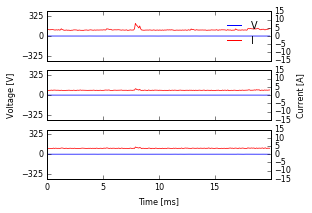

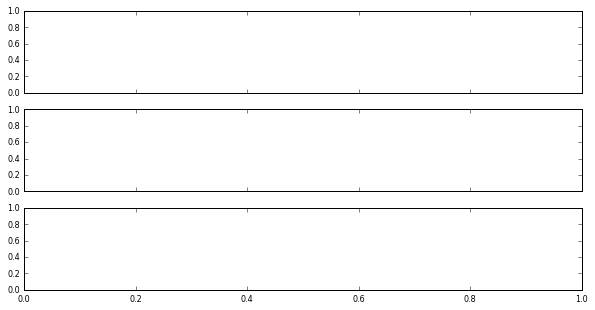

In [11]:
LOCAL_PATH_PREFIX = '/nilmtk/data/summary-2017-04-30-medal-1.hdf5' #'clear-2017-04-30T23*.hdf5'
fileList = glob.glob(LOCAL_PATH_PREFIX)

for file in fileList:
    with h5py.File(file, 'r', driver='core') as f:
        fig, ax = plt.subplots(3)
        for i in range(3):
            voltage_name = 'real_power' + str(i + 1) #'voltage' + str(i + 1)
            current_name = 'apparent_power' + str(i + 1) #'current' + str(i + 1)
            start = 61870
            stop = start + int(f.attrs['frequency'] / 50 * 2)

            ax[i].plot(f[voltage_name][start:stop], #* f[voltage_name].attrs['calibration_factor'],
                       'blue',
                       linewidth=0.75)
            ax[i].set_ylim(-400, 400)
            ax[i].set_yticks([-325, 0, 325])
            if i == 1:
                ax[i].set_ylabel('Voltage [V]')

            ax2 = ax[i].twinx()
            ax2.plot(f[current_name][start:stop] * f[current_name].attrs['calibration_factor'],
                     'red',
                     linewidth=0.75)
            ax2.set_ylim(-15, 15)
            ax2.set_xlim(0, stop - start)
            ax2.set_xticks(np.arange(0, f.attrs['frequency'] / 50 * 2, f.attrs['frequency'] / 50 / 2))

            if i == 1:
                ax2.set_ylabel('Current [A]')

        fig.legend(handles=[mlines.Line2D([], [], color='blue'), mlines.Line2D([], [], color='red')],
                   labels=['V', 'I'],
                   frameon=False,
                   bbox_to_anchor=(0.925, 0.93))
        plt.setp(ax[0].get_xticklabels(), visible=False)
        plt.setp(ax[1].get_xticklabels(), visible=False)
        ax[2].set_xticklabels(np.arange(0, 40, 5))
        ax[2].set_xlabel('Time [ms]')

        fig.set_size_inches(4.0, 3.0)
    # %%
year, month, day = 2017, 3, 2
max_power = 1300
smoothing = 30
facecolors = ['#aaaaaaaa', '#ee4035', '#f37736', '#fdf498', '#7bc043', '#0392cf']
clear_medal_mapping = {
    1: [1, 2, 3, 7, 12],
    2: [6, 10, 11, 13, 14],
    3: [4, 5, 8, 9, 15]
}


clear_hdf5_file = os.path.join(LOCAL_PATH_PREFIX, 'BLOND-50/{:04d}-{:02d}-{:02d}/clear/summary-{:04d}-{:02d}-{:02d}-clear.hdf5'.format(year, month, day, year, month, day))
medal_hdf5_files = glob.glob(os.path.join(LOCAL_PATH_PREFIX, 'BLOND-50/{:04d}-{:02d}-{:02d}/medal-*/summary-{:04d}-{:02d}-{:02d}-medal-*.hdf5'.format(year, month, day, year, month, day)))

plt.figure()
fig, ax = plt.subplots(3, sharex=True)

with h5py.File(clear_hdf5_file, 'r', driver='core') as f:
    delay_after_midnight = f.attrs['delay_after_midnight']
    clear_powers = [f[n][:] for n in list(f) if 'apparent_power' in n]
    clear_powers = [np.pad(power, (smoothing - divmod(len(power), smoothing)[1], 0), 'constant', constant_values=0) for power in clear_powers]
    clear_powers = [np.median(power.reshape(-1, smoothing), axis=1) for power in clear_powers]

time_scale = np.arange(delay_after_midnight, delay_after_midnight + len(clear_powers[0]) * smoothing, smoothing) / (60 * 60)
for j, clear_power in enumerate(clear_powers):
    ax[j].plot(time_scale, clear_power, linewidth=0.8, color='black')
    ax[j].set_ylim(0, max_power)
    ax[j].set_ylabel('Power L{} [W]'.format(j + 1))
    ax[j].set_yticks(range(0, 1500, 250))


medals = []
for medal_file in sorted(medal_hdf5_files):
    with h5py.File(medal_file, 'r', driver='core') as f:
        powers = [f[n][:] for n in list(f) if 'apparent_power' in n]
        delay_after_midnight = f.attrs['delay_after_midnight']
    power = np.vstack(powers)
    power = np.sum(power, axis=0)
    power -= np.min(power)
    power = np.insert(power, 0, np.zeros(delay_after_midnight))

    sum_power = np.sum(power)
    medal_id = int(re.match('.+/medal-(?P<id>.+)/.+', medal_file).groupdict()['id'])
    for clear, values in clear_medal_mapping.items():
        if medal_id in values:
            clear_id = clear
            break

    medals.append((sum_power, clear_id, medal_id, power))

max_length = np.max([len(power) for _, _, _, power in medals])

baseloads = [380, 80, 150]
for clear_id in range(1, 4):
    powers = [np.ones(max_length) * baseloads[clear_id - 1]]
    powers += [power for _, cid, _, power in sorted(medals) if clear_id == cid]
    powers = [np.append(power, np.zeros(max_length - len(power))) for power in powers]
    powers = [np.pad(power, (smoothing - divmod(len(power), smoothing)[1], 0), 'constant', constant_values=0) for power in powers]
    powers = [np.median(power.reshape(-1, smoothing), axis=1) for power in powers]

    time_scale = np.arange(0, len(powers[0]) * smoothing, smoothing) / (60 * 60)
    ax[clear_id - 1].stackplot(time_scale, powers, colors=facecolors, labels=[medal_id for _, _, medal_id, _ in sorted(medals)])

    rects = [matplotlib.patches.Rectangle((0, 0), 1, 1, facecolor=facecolors[i + 1]) for i in range(len(powers[1:]))]
    labels = ['MEDAL-{}'.format(medal_id) for _, cid, medal_id, _ in sorted(medals) if clear_id == cid]
    ids = [medal_id for _, cid, medal_id, _ in sorted(medals) if clear_id == cid]
    h = sorted(zip(ids, rects, labels))
    ax[clear_id - 1].legend(handles=[r for i, r, l in h],
                            labels=[l for i, r, l in h],
                            loc='upper right',
                            frameon=False,
                            bbox_to_anchor=(1.17, 1.0))

ax[0].set_title("Apparent Power - {:04d}-{:02d}-{:02d}".format(year, month, day))

plt.xticks(list(range(0, 26, 1)), ['{}:00'.format(j) for j in range(0, 26, 1)], rotation='vertical')
ax[-1].set_xlim(5.5, 20.5)
ax[-1].set_xlabel('Time of the day')

fig.set_size_inches(8.0, 5.5)
fig.savefig('daily-consumption.pdf', bbox_inches='tight')
